# Trust Experiments

Here we look at the effect of constant vs. dynamic physician trust in our model. We do this for various initial FPR rates as the relation between final (converged) FPR and the physician trust depends heavily on initial FPR. We'll use `sklearn.datasets.make_classification` to generate the data

In [61]:
import copy
import numpy as np
import torch

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import sklearn.linear_model as linear_model


from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_constant_trust, update_model_conditional_trust, update_model_monotonically_increasing_trust, update_model_increasing_trust

## Update Model --> Constant Trust

In [ ]:
seeds = np.arange(100)
trust_rates = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
physician_fprs = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]
fprs = {trust: {physician_fpr: [] for physician_fpr in physician_fprs} for trust in trust_rates}

for seed in seeds:
    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)

    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    for trust in trust_rates:
        for physician_fpr in physician_fprs:
            new_model = update_model_constant_trust(model, x_update, y_update, 1000, trust, physician_fpr)
        
            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            fprs[trust][physician_fpr].append(updated_fpr)

In [52]:
data = {"fpr": [], "physician_fpr": [], "trust": []}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        data["fpr"] += fprs[trust][physician_fpr]
        data["physician_fpr"] += [physician_fpr] * len(fprs[trust][physician_fpr])
        data["trust"] += [trust] * len(fprs[trust][physician_fpr])

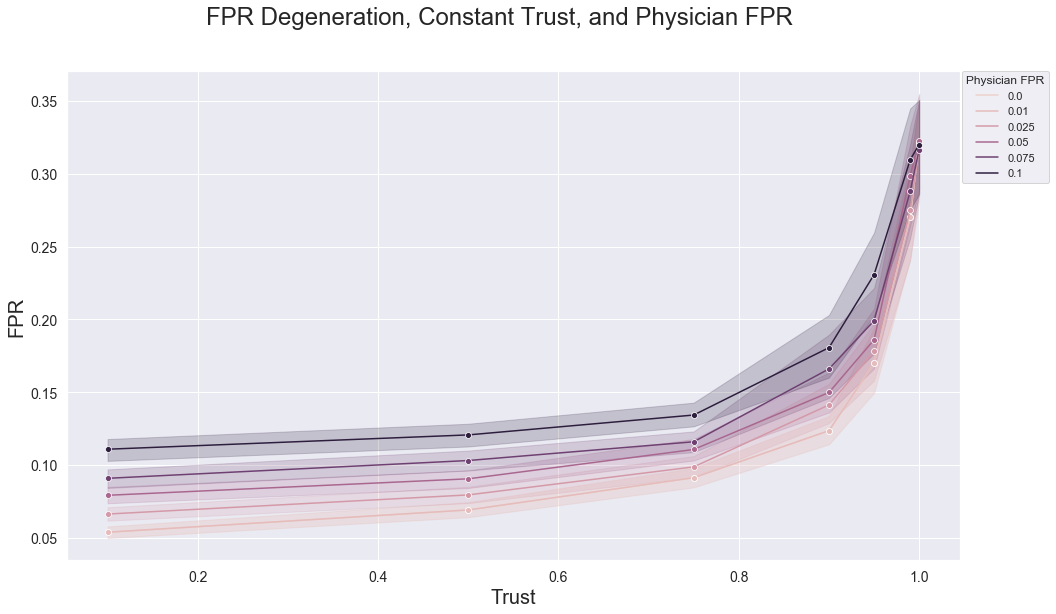

In [54]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Constant Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Trust", fontsize=20)
g = sns.lineplot(x="trust", y="fpr", hue="physician_fpr", data=data, legend="full",marker="o", ax=ax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0.95, box.height]) # resize position

# Put a legend to the right side

g.legend(title="Physician FPR", loc='upper right',  ncol=1, bbox_to_anchor=(1.1, 1), borderaxespad=0.)
fig.show()
fig.savefig("figures/trust/constant_trust.png)

## Update Model --> Trust Decreasing with FPR

In [55]:
seeds = np.arange(100)

trust_rates = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
physician_fprs = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]
fprs = {trust: {physician_fpr: [] for physician_fpr in physician_fprs} for trust in trust_rates}

for seed in seeds:
    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)

    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

    for trust in trust_rates:
        for physician_fpr in physician_fprs:
            new_model = update_model_conditional_trust(model, x_update, y_update, 1000, trust, physician_fpr)

            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            fprs[trust][physician_fpr].append(updated_fpr)

KeyboardInterrupt: 

In [ ]:
data = {"fpr": [], "physician_fpr": [], "trust": []}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        data["fpr"] += fprs[trust][physician_fpr]
        data["physician_fpr"] += [physician_fpr] * len(fprs[trust][physician_fpr])
        data["trust"] += [trust] * len(fprs[trust][physician_fpr])

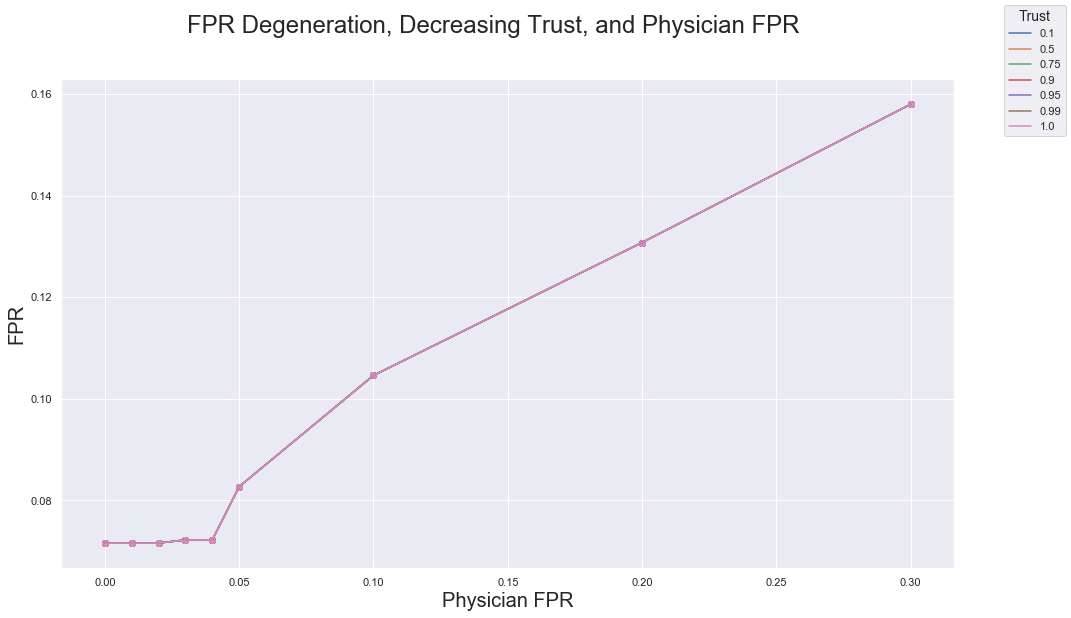

In [5]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Decreasing Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Trust", fontsize=20)
g = sns.lineplot(x="trust", y="fpr", hue="physician_fpr", data=data, marker="o", ax=ax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0.95, box.height]) # resize position

# Put a legend to the right side

g.legend(title="Physician FPR", loc='upper right',  ncol=1, bbox_to_anchor=(1.1, 1), borderaxespad=0.)
fig.show()

## Update Model --> Monotonically Linearly Increasing Trust

In [56]:
seeds = np.arange(100)

trust_rates = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
physician_fprs = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]
fprs = {trust: {physician_fpr: [] for physician_fpr in physician_fprs} for trust in trust_rates}

for seed in seeds:
    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)

    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    for trust in trust_rates:
        for physician_fpr in physician_fprs:
            new_model = update_model_monotonically_increasing_trust(model, x_update, y_update, 1000, trust, physician_fpr)

            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            fprs[trust][physician_fpr].append(updated_fpr)

In [57]:
data = {"fpr": [], "physician_fpr": [], "trust": []}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        data["fpr"] += fprs[trust][physician_fpr]
        data["physician_fpr"] += [physician_fpr] * len(fprs[trust][physician_fpr])
        data["trust"] += [trust] * len(fprs[trust][physician_fpr])

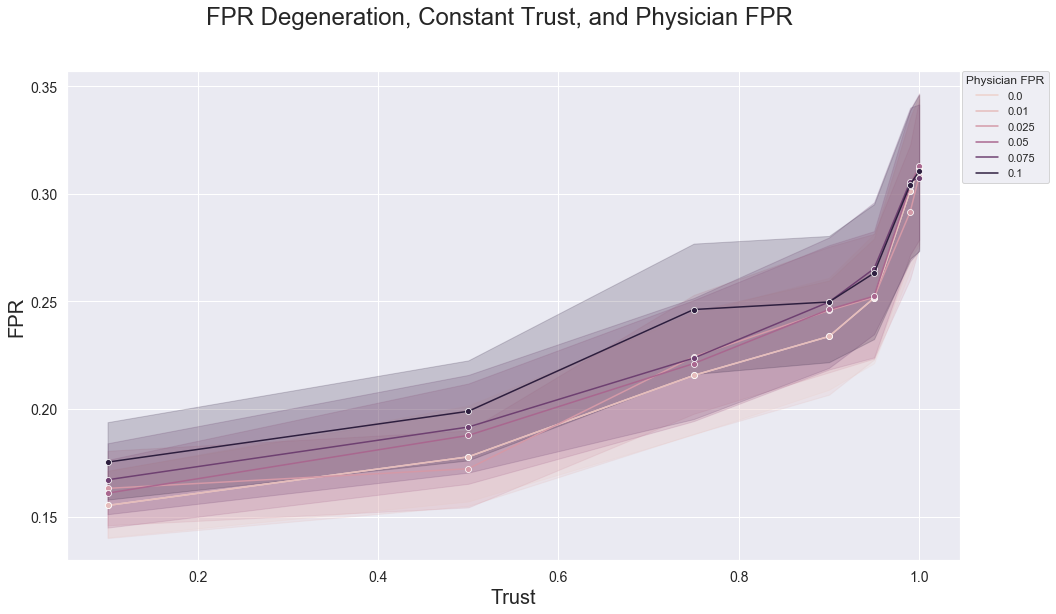

In [58]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Linearly Increasing Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Trust", fontsize=20)
g = sns.lineplot(x="trust", y="fpr", hue="physician_fpr", data=data, legend="full",marker="o", ax=ax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0.95, box.height]) # resize position

# Put a legend to the right side

g.legend(title="Physician FPR", loc='upper right',  ncol=1, bbox_to_anchor=(1.1, 1), borderaxespad=0.)
fig.show()
fig.savefig("figures/trust/linearly_increasing_trust.png")

## Update Model --> Exponentially increasing Trust

In [62]:
def logit_from_trust(trust):
    return - np.log((1.0 / trust) - 1)

In [75]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [76]:
seeds = np.arange(10)
trust_ub = logit_from_trust(0.9999)
trust_ub = np.log10(trust_ub)

trust_rates = [0.55, 0.75, 0.9, 0.95, 0.99, 0.999]
physician_fprs = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]
fprs = {trust: {physician_fpr: [] for physician_fpr in physician_fprs} for trust in trust_rates}

for seed in seeds:
    x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)

    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
    
    for trust in trust_rates:
        for physician_fpr in physician_fprs:
            
            trust_lb = logit_from_trust(trust)
            trust_lb = np.log10(trust_lb)
            
            trusts = np.logspace(trust_lb, trust_ub, num=1000)
            trusts = sigmoid(trusts)
            new_model = update_model_increasing_trust(model, x_update, y_update, 1000, trusts, physician_fpr)

            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            fprs[trust][physician_fpr].append(updated_fpr)

In [77]:
data = {"fpr": [], "physician_fpr": [], "trust": []}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        data["fpr"] += fprs[trust][physician_fpr]
        data["physician_fpr"] += [physician_fpr] * len(fprs[trust][physician_fpr])
        data["trust"] += [trust] * len(fprs[trust][physician_fpr])

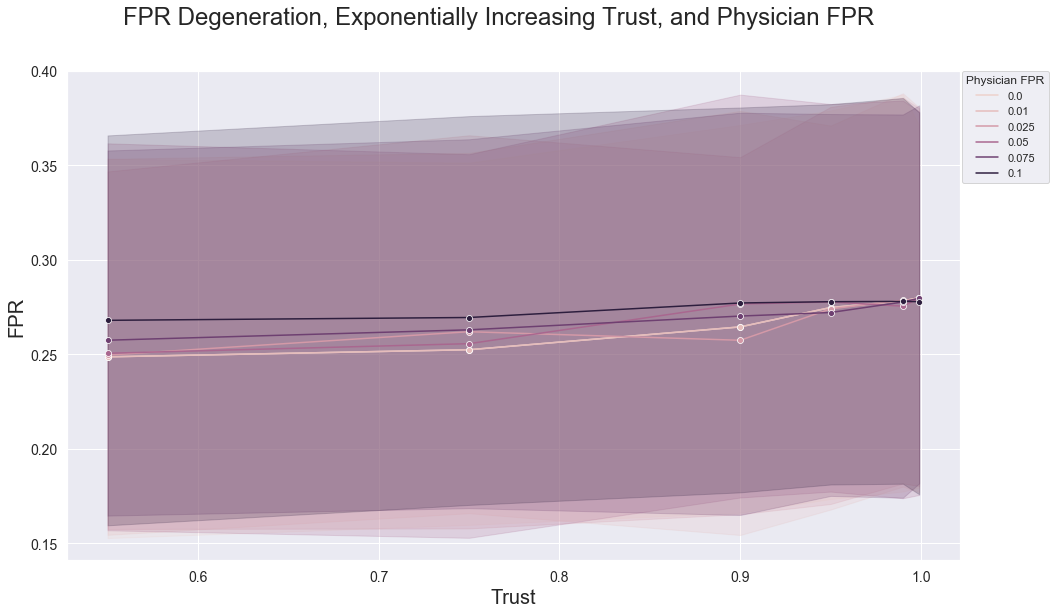

In [78]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Exponentially Increasing Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Trust", fontsize=20)
g = sns.lineplot(x="trust", y="fpr", hue="physician_fpr", data=data, legend="full",marker="o", ax=ax)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0.95, box.height]) # resize position

# Put a legend to the right side

g.legend(title="Physician FPR", loc='upper right',  ncol=1, bbox_to_anchor=(1.1, 1), borderaxespad=0.)
fig.show()
fig.savefig("figures/trust/exponentially_increasing_trust.png")